# Merck Challenge
## Bayesian optimization for Hyper parameter optimization

- Vanshita Gupta
- Advaith Rao

## Import packages

In [2]:
# !pip3 install scikit-optimize
%matplotlib inline
import numpy as np
np.random.seed(237)
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from skopt.plots import plot_gaussian_process
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from olympus import Emulator, Dataset
from olympus.models import BayesNeuralNet
from olympus.emulators.emulator import load_emulator

# from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score,train_test_split

from sklearn.metrics import r2_score

In [3]:
import tensorflow as tf
#!pip3 install tensorflow_probability
import tensorflow_probability as tf_prob

## Load our dataset

In [4]:

dataset = Dataset(kind='alkox')
data = dataset.data

/Users/arao/Desktop/test_env/lib/python3.8/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## Data Summary

In [5]:
data

,residence_time,ratio,concentration,temperature,conversion
0,0.05,0.5,2.0,6.0,5.932566
1,0.05,0.5,2.0,6.0,5.932566
2,0.05,0.5,2.0,7.0,2.173315
3,0.05,0.5,2.0,7.0,2.173315
4,0.05,0.5,2.0,8.0,1.056175
...,...,...,...,...,...
203,1.00,10.0,8.0,6.0,8.643051
204,1.00,10.0,8.0,7.0,15.471287
205,1.00,10.0,8.0,7.0,15.471287
206,1.00,10.0,8.0,8.0,5.071760


In [6]:
data.describe()

,residence_time,ratio,concentration,temperature,conversion
count,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.502885,5.254808,5.057692,7.009615,11.915898
std,0.387475,3.852971,2.205951,0.816440,14.338136
min,0.050000,0.500000,2.000000,6.000000,0.000000
25%,0.050000,0.500000,4.000000,6.000000,4.034892
50%,0.500000,5.000000,6.000000,7.000000,7.726216
75%,1.000000,10.000000,6.500000,8.000000,15.535034
max,1.000000,10.000000,8.000000,8.000000,106.480942


## Standardize our data

In [8]:
# demonstrate data normalization with sklearn

# load data
#data = ...
# create scaler
scaler = StandardScaler()
# fit and transform in one step
data = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)
print(data)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]


     residence_time     ratio  concentration  temperature  conversion
0         -1.171631 -1.237040      -1.389455    -1.239591   -0.418309
1         -1.171631 -1.237040      -1.389455    -1.239591   -0.418309
2         -1.171631 -1.237040      -1.389455    -0.011806   -0.681127
3         -1.171631 -1.237040      -1.389455    -0.011806   -0.681127
4         -1.171631 -1.237040      -1.389455     1.215980   -0.759229
..              ...       ...            ...          ...         ...
203        1.286058  1.234538       1.337022    -1.239591   -0.228812
204        1.286058  1.234538       1.337022    -0.011806    0.248566
205        1.286058  1.234538       1.337022    -0.011806    0.248566
206        1.286058  1.234538       1.337022     1.215980   -0.478490
207        1.286058  1.234538       1.337022     1.215980   -0.478490

[208 rows x 5 columns]


In [9]:
n_features = X.shape[1]
n_features


4

## Model Definition

In [10]:
reg = GradientBoostingRegressor(random_state=0)

## Input Space definition

Define the space over which we test the optimum values of parameters for our model

In [11]:

space = [Integer(1, 1000, name='max_depth'),
Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
Integer(1, n_features, name='max_features'),
Integer(2, 200, name='min_samples_split'),
Integer(1, 200, name='min_samples_leaf'),
Integer(1, 50, name='n_estimators')]

## Objective Function definition

In [12]:
noise_level=0.5
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)
    return -np.mean(cross_val_score(reg, X, y, cv=10, n_jobs=-1,scoring="neg_mean_absolute_error"))

def objective_fn(**params):
   model = GradientBoostingRegressor(random_state=0,**params)
   return -np.mean(cross_val_score(model, X, y, cv=10, n_jobs=-1,scoring="neg_mean_absolute_error"))


## Run Bayesian optimization with the *Gaussian Process Regressor* surrogate function and *Expected Improvement* acquision function

In [14]:
res_gp = gp_minimize(objective, space, n_calls=20,noise=0.1**2,acq_func='EI', random_state=101)
"Best score=%.4f" % res_gp.fun

'Best score=0.6296'

## Print the best values of parameters for our model

In [15]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- n_estimators=%d
- Minima of function=%.4f""" % (res_gp.x[0], res_gp.x[1],
res_gp.x[2], res_gp.x[3],
res_gp.x[4], res_gp.x[5],
res_gp.fun))

Best parameters:
- max_depth=39
- learning_rate=0.008433
- max_features=1
- min_samples_split=78
- min_samples_leaf=58
- n_estimators=40
- Minima of function=0.6296


## Make the convergence plot

Check the iteration number at which our function converges at the minimum value of f(x)

<AxesSubplot: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

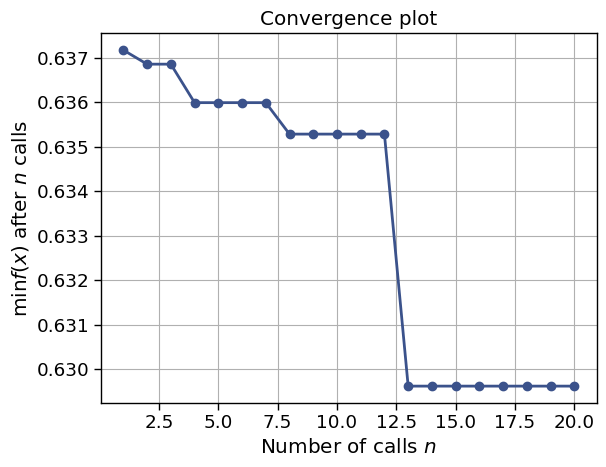

In [16]:
plot_convergence(res_gp)

## Try different acquision functions

Try to see how different acquision functions affect our convergence at the minima.

In [304]:
res_gp_EI = gp_minimize(objective, space, n_calls=100,acq_func='EI', random_state=101)
res_gp_LCB = gp_minimize(objective, space, n_calls=100,acq_func='LCB', random_state=101)
res_gp_LCB_K5 = gp_minimize(objective, space, n_calls=100,acq_func='LCB', random_state=101,kappa=5)
res_gp_LCB_K10 = gp_minimize(objective, space, n_calls=100,acq_func='LCB', random_state=101,kappa=10)
res_gp_gp_hedge = gp_minimize(objective, space, n_calls=100, random_state=101)

## Make the convergence plot for all the above optimizers

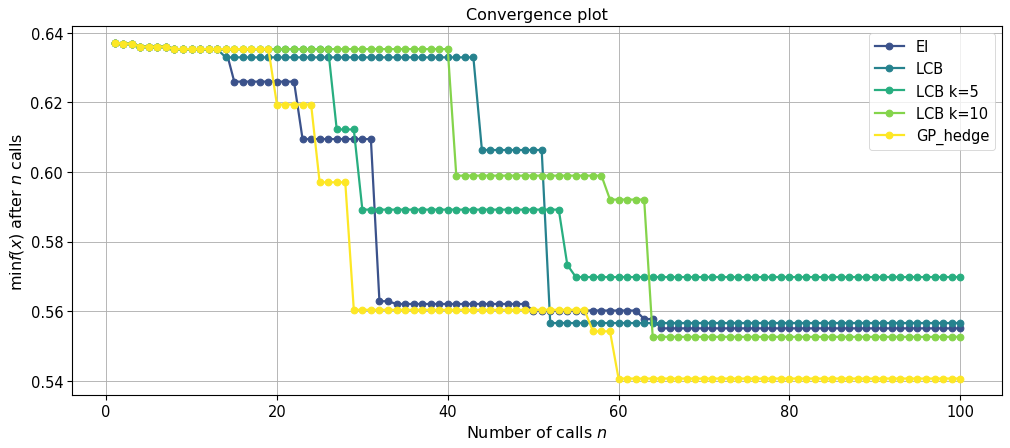

In [305]:
plt.figure(figsize=(15, 6), dpi=80)
plot = plot_convergence(
    ("EI"       , res_gp_EI),
    ("LCB"      , res_gp_LCB),
    ("LCB k=5"  , res_gp_LCB_K5),
    ("LCB k=10" , res_gp_LCB_K10),
    ("GP_hedge" , res_gp_gp_hedge)
    )
#, yscale="log")
plt.show()

**After looking at the Convergence plot we can deduce acquisition function gp_hedge gives the best convergence at minima for our function**

## Try different random states for the best acquision function

Try to see how for the best acquision functions(*gp_hedge* in this case), using different random states affect our convergence at the minima.

In [17]:
res_gp_1 = gp_minimize(objective, space, n_calls=100, random_state=101)
res_gp_2 = gp_minimize(objective, space, n_calls=100, random_state=201)
res_gp_3 = gp_minimize(objective, space, n_calls=100, random_state=301)
res_gp_4 = gp_minimize(objective, space, n_calls=100, random_state=401)
res_gp_5 = gp_minimize(objective, space, n_calls=100, random_state=501)

## Make the convergence plot for all the above random states

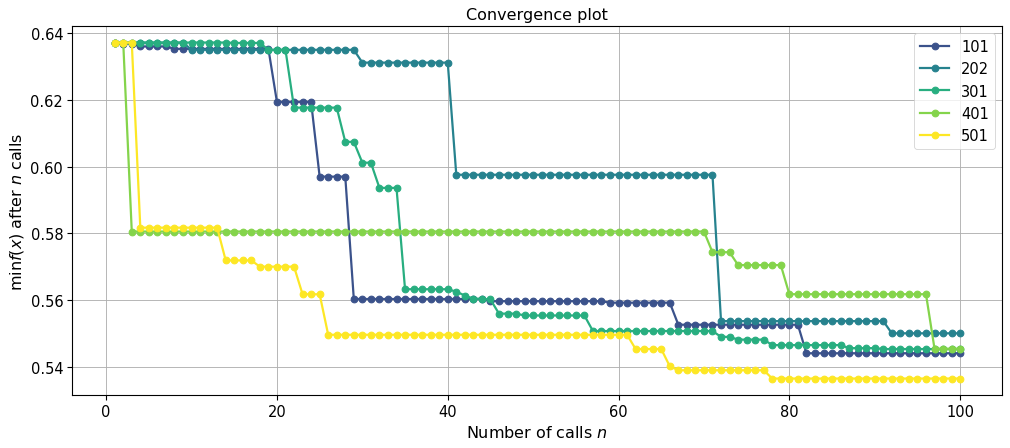

In [18]:
plt.figure(figsize=(15, 6), dpi=80)
plot = plot_convergence(
    ("101" , res_gp_1),
    ("202" , res_gp_2),
    ("301" , res_gp_3),
    ("401" , res_gp_4),
    ("501" , res_gp_5)
    )
#, yscale="log")
plt.show()

## Conclusion

In [19]:
res_gp_best = gp_minimize(objective, space, n_calls=100, random_state=101)
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- n_estimators=%d
- Minima of function=%.4f""" % (res_gp_best.x[0], res_gp_best.x[1],
res_gp_best.x[2], res_gp_best.x[3],
res_gp_best.x[4], res_gp_best.x[5],
res_gp_best.fun))

Best parameters:
- max_depth=743
- learning_rate=0.108132
- max_features=1
- min_samples_split=50
- min_samples_leaf=41
- n_estimators=50
- Minima of function=0.5441
